In [1]:
from centroid_network.utils import *
from centroid_network.CentroidNetwork import CentroidNetwork
from centroid_network.CentroidLayer import CentroidLayer

from sklearn.model_selection import train_test_split

# 1. Load the dataset (30-D MNIST after PCA). Divide into train/test sub-datasets (0.3 test, 0.7 train). Separate labels from the datasets.

In [2]:
# read dataset
dataset = read_dataset("./mnist_70k_pca30.csv")

# normalize input
dataset = normalize_input(dataset)

# split the dataset
dataset_train, dataset_test = train_test_split(dataset, test_size=0.3, random_state=42)

data_train, labels_train = separate_labels_from_dataset(dataset_train)
data_test, labels_test = separate_labels_from_dataset(dataset_test)

# 2. Create Centroid Network (CN) and one Centroid Layer (CL0). Layer is created with M=15 (which means, that it should calculate 15 centroids in each class).

In [3]:
M = 15

CN = CentroidNetwork()

CL0 = CentroidLayer(m=M)
CN.append_layer(CL0)

# 3. Train the network using data_train and labels_train (obtained in step 1)

In [4]:
CN.train(data_train, labels_train)


100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


[Layer 0] Training the network (calculating centroids)...
[Layer 0] Feeding data forward...


# 4. Convert data and labels into numpy arrays.

In [5]:
data_to_plot = data_train.to_numpy()
labels_to_plot = labels_train.to_numpy()

# 5. Convert centroids calculated by the network (step 3) into numpy arrays. Add centroid coordinates and labels to main dataset (which will be forwarded to t-SNE and plotting)

In [6]:
from typing import Dict, List

centroids_to_plt = CN.layers[0].centroids

def convert_dict_to_lists(data_set: Dict[Label, DataPoint]) -> [List[Label], List[float]]:
    labels = []
    data_points = []
    for label, points in data_set.items():
        for point in points:
            labels.append(label)
            data_points.append(point.coordinates)

    return labels, data_points

centroids_labels, centroids = convert_dict_to_lists(centroids_to_plt)

for centroid in centroids:
    centroid = centroid[:, None]
    data_to_plot = np.append(data_to_plot, centroid.T, axis=0)

for label in centroids_labels:
    labels_to_plot = np.append(labels_to_plot, label)

# 6. Embed the data (both training dataset and centroids calculated by the network) using t-SNE method.

In [7]:
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_to_plot)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 49150 samples in 0.148s...
[t-SNE] Computed neighbors for 49150 samples in 192.717s...
[t-SNE] Computed conditional probabilities for sample 1000 / 49150
[t-SNE] Computed conditional probabilities for sample 2000 / 49150
[t-SNE] Computed conditional probabilities for sample 3000 / 49150
[t-SNE] Computed conditional probabilities for sample 4000 / 49150
[t-SNE] Computed conditional probabilities for sample 5000 / 49150
[t-SNE] Computed conditional probabilities for sample 6000 / 49150
[t-SNE] Computed conditional probabilities for sample 7000 / 49150
[t-SNE] Computed conditional probabilities for sample 8000 / 49150
[t-SNE] Computed conditional probabilities for sample 9000 / 49150
[t-SNE] Computed conditional probabilities for sample 10000 / 49150
[t-SNE] Computed conditional probabilities for sample 11000 / 49150
[t-SNE] Computed conditional probabilities for sample 12000 / 49150
[t-SNE] Computed conditional probabilities for 

Below: Separate embeddings (and labels) of dataset
from embeddings of centroids.

In [8]:
cut_length = M * len(CN.input.keys())
df = defaultdict()
df['tsne-2d-one'] = tsne_results[:-cut_length, 0]
df['tsne-2d-two'] = tsne_results[:-cut_length, 1]
df['label'] = labels_to_plot[:-cut_length]

df['tsne-centroids-2d-one'] = tsne_results[-cut_length:, 0]
df['tsne-centroids-2d-two'] = tsne_results[-cut_length:, 1]
df['label-centroid'] = labels_to_plot[-cut_length:]

# 7. Plot centroids obtained for the training dataset.

<AxesSubplot:xlabel='tsne-centroids-2d-one', ylabel='tsne-centroids-2d-two'>

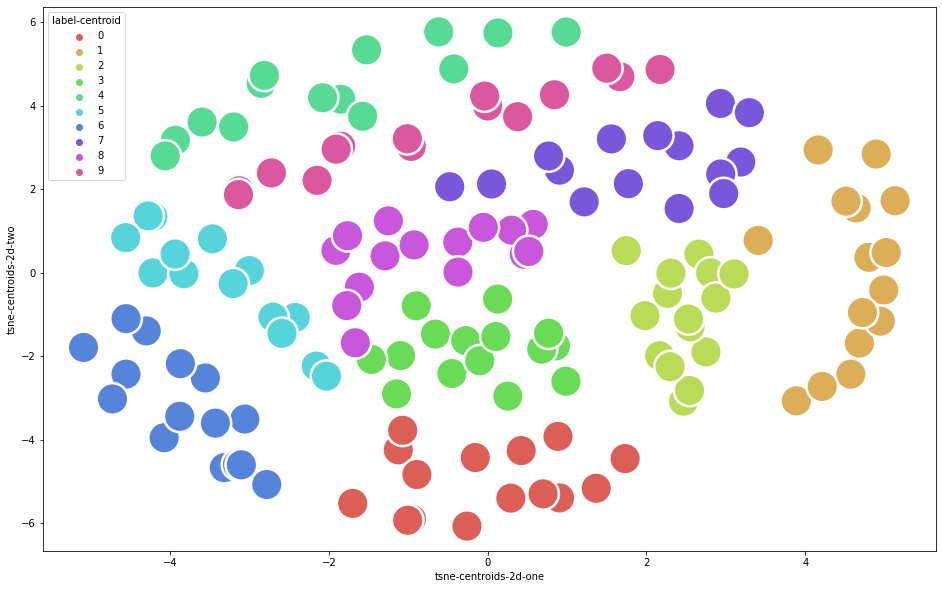

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 10))

sns.scatterplot(
    x="tsne-centroids-2d-one", y="tsne-centroids-2d-two",
    hue="label-centroid",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=1.0,
    s=1000
)

# 8. Plot both centroids and training dataset.

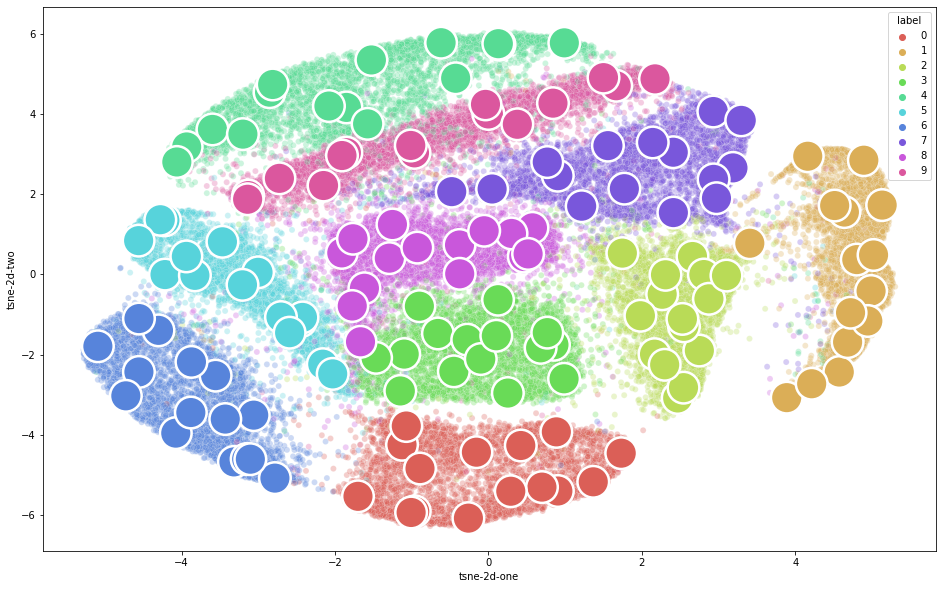

In [10]:
plt.figure(figsize=(16, 10))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

sns.scatterplot(
    x="tsne-centroids-2d-one", y="tsne-centroids-2d-two",
    hue="label-centroid",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend=None,
    alpha=1.0,
    s=1000
)

plt.show()

# 9. Use CN to "embed" the test sub-dataset - 'data_test'. 'number_of_elements' is variable determining how many distances will be taken into account, when predicting the class to which data belongs to.

In return we obtain predicted labels and created embedding for t

In [11]:
predicted_labels, embeddings = CN.predict(X=data_test, number_of_elements=3)

100%|██████████| 21000/21000 [00:34<00:00, 607.04it/s]


[Layer 0] Feeding datapoints forward...
Predicting labels for datapoints...
Prediction finished.


# 10. Calculate the score with evaluate method. It takes predicted labels (from step 9) and test labels (from step 1) into account.

In [12]:
score = evaluate(labels_test, predicted_labels)
print("Score is: {}".format(score))

Evaluating test dataset...
Score is: 0.9257619047619048


# 11. Convert embeddings and predicted labels to numpy arrays (again for t-SNE).

In [13]:
embeddings_to_plot = []
for embedding in embeddings:
    embeddings_to_plot.append(embedding.coordinates)

predicted_labels = predicted_labels.to_numpy()

# 12. Calculate t-SNE embeddings of calculated CN embeddings (each CN embedding has 15D).

In [14]:
from sklearn.manifold import TSNE

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embeddings_to_plot)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 21000 samples in 0.031s...
[t-SNE] Computed neighbors for 21000 samples in 7.885s...
[t-SNE] Computed conditional probabilities for sample 1000 / 21000
[t-SNE] Computed conditional probabilities for sample 2000 / 21000
[t-SNE] Computed conditional probabilities for sample 3000 / 21000
[t-SNE] Computed conditional probabilities for sample 4000 / 21000
[t-SNE] Computed conditional probabilities for sample 5000 / 21000
[t-SNE] Computed conditional probabilities for sample 6000 / 21000
[t-SNE] Computed conditional probabilities for sample 7000 / 21000
[t-SNE] Computed conditional probabilities for sample 8000 / 21000
[t-SNE] Computed conditional probabilities for sample 9000 / 21000
[t-SNE] Computed conditional probabilities for sample 10000 / 21000
[t-SNE] Computed conditional probabilities for sample 11000 / 21000
[t-SNE] Computed conditional probabilities for sample 12000 / 21000
[t-SNE] Computed conditional probabilities for sa

In [15]:
df_predict = defaultdict()
df_predict['tsne-2d-one'] = tsne_results[:, 0]
df_predict['tsne-2d-two'] = tsne_results[:, 1]
df_predict['label'] = predicted_labels

# 13. Plot t-SNE result (of embedding CN output).

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 10))

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="label",
    palette=sns.color_palette("hls", 10),
    data=df_predict,
    legend="full",
    alpha=0.5
)